# Notebook Initialization

In [1]:
# %load nb_init.py

from pathlib import Path
import pandas as pd

base_dir = Path.cwd().parent
config_dir = base_dir / "config"
data_dir = base_dir / "data"
docs_dir = base_dir / "docs"
figures_dir = docs_dir / "figures"
models_dir = base_dir / "models"
logs_dir = base_dir / "logs"
images_input_dir = data_dir / "COVID19"
preprocessed_dir = data_dir / "preprocessed"
output_dir = data_dir / "output"

# Directories used to train the CNN (image by image) 
cnn_data_dir = data_dir / "modelling" / "cnn"
cnn_train_dir = cnn_data_dir / "train"
cnn_test_dir = cnn_data_dir / "test"

metadata_file = images_input_dir / "metadata.csv"
labels_file = images_input_dir / "unzip_filenames.csv"
preprocessed_labels_file = preprocessed_dir / "labels.parquet"

feature_extractor_model_file = models_dir / "feature_extractor.tf"

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

config_file = config_dir / "tfg.conf"

from pyhocon import ConfigFactory
config = None

def load_config():
    return ConfigFactory.parse_file(config_file)

config = load_config()
    
import sys

if str(base_dir / "src") not in sys.path:
    sys.path.append(str(base_dir / "src"))

%load_ext autoreload

%autoreload 2

In [2]:
spark

In [3]:
from tfg import DataRepository

repo = DataRepository(config=config, base_data_path=data_dir)

# Load CNN

In [4]:
from tensorflow.keras.models import load_model
cnn_model_suffix = "07"
model_file = models_dir / f"feature_extractor_{cnn_model_suffix}.tf"
model = load_model(str(model_file))

model.summary()

Model: "covid_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_images (InputLayer)    [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_01 (Conv2D)           (None, 64, 64, 6)         168       
_________________________________________________________________
maxpool2d_01 (MaxPooling2D)  (None, 32, 32, 6)         0         
_________________________________________________________________
conv2d_02 (Conv2D)           (None, 32, 32, 12)        660       
_________________________________________________________________
maxpool2d_02 (MaxPooling2D)  (None, 16, 16, 12)        0         
_________________________________________________________________
conv2d_03 (Conv2D)           (None, 16, 16, 18)        1962      
_________________________________________________________________
maxpool2d_03 (MaxPooling2D)  (None, 8, 8, 18)     

# Load datasets

In [5]:
# img_size = config.get_int("tfg.training.img_size")
img_size = 64
image_target_size = (img_size, img_size)
seed = config.get_int("tfg.seed")
batch_size = config.get_int("tfg.training.batch_size")

In [6]:
from keras_preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(
    rescale=1./255.,
)

# Predictions function

In [14]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType


def create_vote_predictions(df, datagen, config, img_base_dir, spark):
    #img_size = config.get_int("tfg.training.img_size")
    img_size = 64#config.get_int("tfg.training.img_size")
    image_target_size = (img_size, img_size)
    seed = config.get_int("tfg.seed")
    batch_size = config.get_int("tfg.training.batch_size")
    
    df_generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory=str(img_base_dir),
        x_col="file",
        y_col="label",
        batch_size=batch_size,
        seed=seed,
        shuffle=False,
        class_mode="categorical",
        target_size=image_target_size)
    
    class_to_idx = df_generator.class_indices
    idx_to_class = { v: k for k, v in class_to_idx.items() }
    
    NUM_BATCHES = df_generator.n // df_generator.batch_size + 1
    
    raw_preds = model.predict(df_generator, steps=NUM_BATCHES, verbose=1)
    preds = raw_preds.argmax(axis=1)
    raw_preds_list = raw_preds.tolist()
    
    cp_index = class_to_idx["CP"]
    ncp_index = class_to_idx["NCP"]
    normal_index = class_to_idx["Normal"]
    
    cp_probs = list(map(lambda probs: probs[cp_index], raw_preds_list))
    ncp_probs = list(map(lambda probs: probs[ncp_index], raw_preds_list))
    normal_probs = list(map(lambda probs: probs[normal_index], raw_preds_list))
    
    cp_preds = (preds == cp_index).astype("int")
    ncp_preds = (preds == ncp_index).astype("int")
    normal_preds = (preds == normal_index).astype("int")
    
    df["cp_prob"] = cp_probs
    df["ncp_prob"] = ncp_probs
    df["normal_prob"] = normal_probs
    df["cp_pred"] = cp_preds
    df["ncp_pred"] = ncp_preds
    df["normal_pred"] = normal_preds
    df["pred"] = list(map(lambda idx: idx_to_class[idx], preds.tolist()))
    
    sdf = spark.createDataFrame(df)
    scan_preds = sdf\
        .groupBy("patient_id", "scan_id")\
        .agg(
            F.first("label").alias("label"),
            F.first("n_slice").alias("n_slice"),
            F.first("num_clips").alias("num_clips"),
            F.avg("cp_prob").alias("cp_prob"),
            F.avg("ncp_prob").alias("ncp_prob"),
            F.avg("normal_prob").alias("normal_prob"),
            F.sum("cp_pred").alias("cp_votes"),
            F.sum("ncp_pred").alias("ncp_votes"),
            F.sum("normal_pred").alias("normal_votes"),
            F.stddev("cp_prob").alias("stddev_cp_prob"),
            F.stddev("ncp_prob").alias("stddev_ncp_prob"),
            F.stddev("normal_prob").alias("stddev_normal_prob")
        )


    def _get_pred_prob(cp_prob, ncp_prob, normal_prob, stddev_cp_prob, stddev_ncp_prob, stddev_normal_prob):
        max_prob = max(cp_prob, ncp_prob, normal_prob)
        
        preds = [
            ("CP", cp_prob, stddev_cp_prob),
            ("NCP", ncp_prob, stddev_ncp_prob),
            ("Normal", normal_prob, stddev_normal_prob),
        ]
        
        # keep only the predictions that have the maximum probability. This should return only 1 in most cases
        max_prob_preds = list(filter(lambda t: t[1] == max_prob, preds))
        
        if len(max_prob_preds) == 1:
            return max_prob_preds[0][0]
        else:
            # if we had more than 1 max prob, keep only the ones with the lowest stddev
            # This should return only 1 in most cases
            min_stddev = min(list(map(lambda t: t[2], max_prob_preds)))
            min_stddev_preds = list(filter(lambda t: t[2] == min_stddev, max_prob_preds))
            possible_preds = [t[0] for t in min_stddev_preds]
            # if we have more than 1 possibility, we just return the first in alphabetical order
            return sorted(possible_preds)[0]
    
    def _get_pred_vote(cp_votes, ncp_votes, normal_votes, cp_prob, ncp_prob, normal_prob, stddev_cp_prob, stddev_ncp_prob, stddev_normal_prob):
        # First, try to return the option with the most votes
        max_votes = max(cp_votes, ncp_votes, normal_votes)
        if cp_prob > ncp_prob and cp_prob > normal_prob:
            return "CP"
        elif ncp_prob > cp_prob and ncp_prob > normal_prob:
            return "NCP"
        elif normal_prob > cp_prob and normal_prob > ncp_prob:
            return "Normal"
        else:
            # there's more than one option with the most votes, fall back to probabilities
            return _get_pred_prob(cp_prob, ncp_prob, normal_prob, stddev_cp_prob, stddev_ncp_prob, stddev_normal_prob)

    get_pred_udf = F.udf(_get_pred_vote, StringType())

    scan_preds = scan_preds\
        .withColumn(
            "pred",
            get_pred_udf(
                F.col("cp_votes"), F.col("ncp_votes"), F.col("normal_votes"),
                F.col("cp_prob"), F.col("ncp_prob"), F.col("normal_prob"),
                F.col("stddev_cp_prob"), F.col("stddev_ncp_prob"), F.col("stddev_normal_prob"),
            )
        )
    head_cols = ["patient_id", "scan_id", "label", "pred", "cp_votes", "ncp_votes", "normal_votes", "cp_prob", "ncp_prob", "normal_prob", "stddev_cp_prob", "stddev_ncp_prob", "stddev_normal_prob"]
    select_cols = head_cols + list(set(scan_preds.columns) - set(head_cols))
    scan_preds = scan_preds.select(*select_cols)
    scan_preds_df = scan_preds.toPandas()
    
    return scan_preds_df

## Training

In [15]:
train_df = repo.load("train_df")
train_scan_preds = create_vote_predictions(train_df, test_datagen, config=config, img_base_dir=images_input_dir, spark=spark)
train_scan_preds.head(5)

Found 331286 validated image filenames belonging to 3 classes.
10353/10353 [==============================] - 2355s 227ms/step


,patient_id,scan_id,label,pred,cp_votes,ncp_votes,normal_votes,cp_prob,ncp_prob,normal_prob,stddev_cp_prob,stddev_ncp_prob,stddev_normal_prob,n_slice,num_clips
0,880,2415,NCP,Normal,0,0,312,0.004712,0.183258,0.812030,0.004037,0.007462,0.004063,312,5
1,1346,3735,CP,CP,53,0,0,0.859106,0.084425,0.056469,0.036074,0.005347,0.032357,53,1
2,1373,3800,CP,CP,55,0,0,0.892330,0.085726,0.021944,0.008092,0.001624,0.009304,55,1
3,1413,3890,CP,CP,66,0,0,0.873117,0.099753,0.027130,0.028105,0.024027,0.013049,66,1
4,1819,274,Normal,Normal,0,0,91,0.010699,0.172375,0.816926,0.005961,0.005714,0.001637,91,2


In [16]:
repo.save("train_preds_vote_final", train_scan_preds)

True

## Validation

In [17]:
val_df = repo.load("val_df")
val_scan_preds = create_vote_predictions(val_df, test_datagen, config=config, img_base_dir=images_input_dir, spark=spark)
val_scan_preds.head(5)

Found 39828 validated image filenames belonging to 3 classes.
1245/1245 [==============================] - 292s 234ms/step


,patient_id,scan_id,label,pred,cp_votes,ncp_votes,normal_votes,cp_prob,ncp_prob,normal_prob,stddev_cp_prob,stddev_ncp_prob,stddev_normal_prob,n_slice,num_clips
0,450,2055,NCP,NCP,7,27,0,0.240975,0.754822,0.004203,0.264456,0.271900,0.009033,34,1
1,566,2290,NCP,NCP,32,128,0,0.213859,0.782471,0.003670,0.283149,0.289650,0.007590,160,3
2,602,2964,CP,CP,82,0,2,0.864852,0.084099,0.051049,0.084814,0.004144,0.085850,84,2
3,1737,1040,Normal,CP,72,0,8,0.732916,0.087574,0.179510,0.152542,0.010095,0.156785,80,2
4,3705,5532,NCP,CP,59,0,4,0.803221,0.083520,0.113259,0.147026,0.006690,0.148754,63,1


In [18]:
repo.save("val_preds_vote_final", val_scan_preds)

True

## Test

In [19]:
test_df = repo.load("test_df")
test_scan_preds = create_vote_predictions(test_df, test_datagen, config=config, img_base_dir=images_input_dir, spark=spark)
test_scan_preds.head(5)

Found 40415 validated image filenames belonging to 3 classes.
1263/1263 [==============================] - 291s 231ms/step


,patient_id,scan_id,label,pred,cp_votes,ncp_votes,normal_votes,cp_prob,ncp_prob,normal_prob,stddev_cp_prob,stddev_ncp_prob,stddev_normal_prob,n_slice,num_clips
0,86,1305,NCP,NCP,9,108,0,0.152548,0.846165,0.001286,0.199917,0.202795,0.003852,117,2
1,171,1486,NCP,NCP,5,138,0,0.051072,0.947658,0.001270,0.137140,0.140139,0.007970,143,3
2,1713,980,Normal,CP,71,0,0,0.884853,0.090829,0.024318,0.023292,0.018831,0.010790,71,2
3,2206,661,Normal,Normal,0,0,77,0.006042,0.181106,0.812852,0.005773,0.008514,0.003722,77,2
4,2758,3289,CP,CP,34,0,1,0.824932,0.084177,0.090891,0.141332,0.006034,0.143610,35,1


In [20]:
repo.save("test_preds_vote_final", test_scan_preds)

True

# Evaluation of the different sets

In [21]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(13, 9)})

In [22]:
import numpy as np
import itertools

sns.set_style("whitegrid", {'axes.grid' : False})

# based on answer from https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
def plot_confusion_matrix(cm, classes,
                          save_to=None,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict={'fontsize' : 26})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt_pct = lambda pct: f"{100 * pct:.2f}%" if normalize else f"{int(100 * pct)}%"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt_pct(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontdict={'fontsize' : 16})

    plt.ylabel('True label', fontdict={'fontsize' : 22})
    plt.xlabel('Predicted label', fontdict={'fontsize' : 22})
    plt.tight_layout()
    
    if save_to:
        plt.savefig(save_to)

In [23]:
def print_metrics(dataset, true_labels, pred_labels):
    prec, rec, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="weighted")
    print(f"{dataset} F1 Score: {100 * f1: .2f}%")
    print(f"{dataset} Precision: {100 * prec: .2f}%")
    print(f"{dataset} Recall: {100 * rec: .2f}%")

In [24]:
class_to_idx = {'CP': 0, 'NCP': 1, 'Normal': 2}
idx_to_class = { v: k for k, v in class_to_idx.items() }
class_labels = [k for k in class_to_idx.keys()]

## Vote-based

### Training

Normalized confusion matrix
[[0.99593165 0.         0.00406835]
 [0.13995118 0.75264443 0.10740439]
 [0.41704036 0.         0.58295964]]


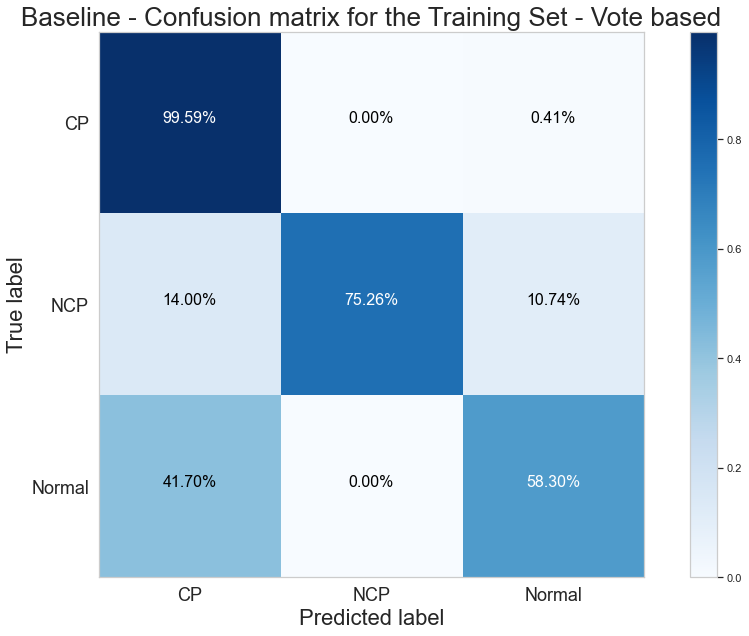

In [25]:
train_preds_df = repo.load("train_preds_vote_final")
train_preds_df["label_idx"] = train_preds_df["label"].apply(class_to_idx.get)
train_preds_df["pred_idx"] = train_preds_df["pred"].apply(class_to_idx.get)
train_true = train_preds_df["label_idx"].values
train_pred = train_preds_df["pred_idx"].values
train_cm = confusion_matrix(train_true, train_pred)

plot_confusion_matrix(
    train_cm,
    classes=class_labels,
    title='Baseline - Confusion matrix for the Training Set - Vote based',
    save_to=figures_dir / "models" / "voting" / f"train_conf_matrix.png")

In [26]:
print_metrics("Training", train_true, train_pred)

Training F1 Score:  79.35%
Training Precision:  83.16%
Training Recall:  79.67%


## Validation

Normalized confusion matrix
[[1.         0.         0.        ]
 [0.14556962 0.7721519  0.08227848]
 [0.45652174 0.         0.54347826]]


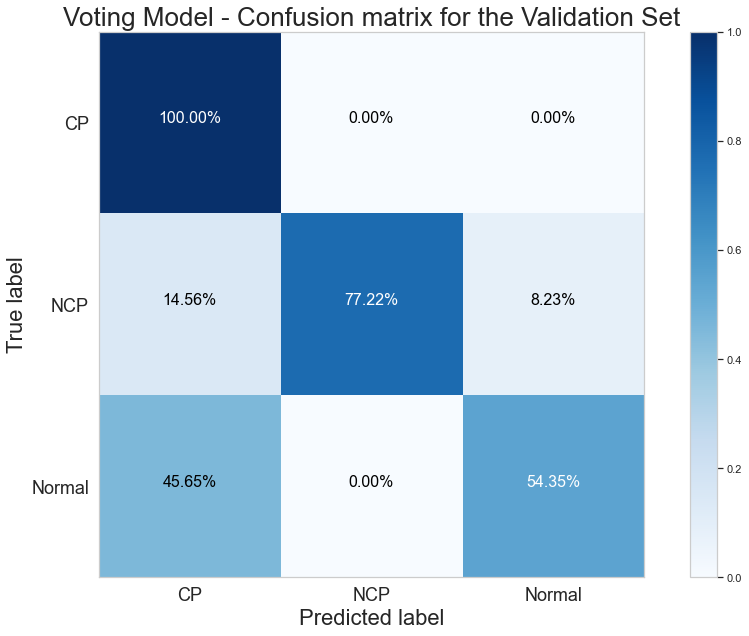

In [27]:
val_preds_df = repo.load("val_preds_vote_final")
val_preds_df["label_idx"] = val_preds_df["label"].apply(class_to_idx.get)
val_preds_df["pred_idx"] = val_preds_df["pred"].apply(class_to_idx.get)
val_true = val_preds_df["label_idx"].values
val_pred = val_preds_df["pred_idx"].values
val_cm = confusion_matrix(val_true, val_pred)

plot_confusion_matrix(
    val_cm,
    classes=class_labels,
    title='Voting Model - Confusion matrix for the Validation Set',
    save_to=figures_dir / "models" / "voting" / f"val_conf_matrix.png")

In [28]:
print_metrics("Validation", val_true, val_pred)

Validation F1 Score:  80.17%
Validation Precision:  83.95%
Validation Recall:  80.60%


## Test

Normalized confusion matrix
[[1.         0.         0.        ]
 [0.1910828  0.73248408 0.07643312]
 [0.27659574 0.         0.72340426]]


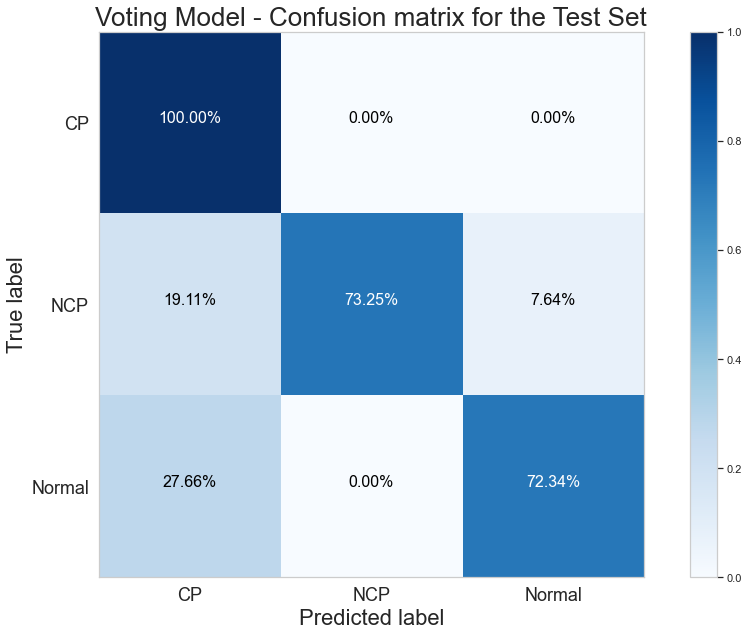

In [29]:
test_preds_df = repo.load("test_preds_vote_final")
test_preds_df["label_idx"] = test_preds_df["label"].apply(class_to_idx.get)
test_preds_df["pred_idx"] = test_preds_df["pred"].apply(class_to_idx.get)
test_true = test_preds_df["label_idx"].values
test_pred = test_preds_df["pred_idx"].values
test_cm = confusion_matrix(test_true, test_pred)

plot_confusion_matrix(
    test_cm,
    classes=class_labels,
    title='Voting Model - Confusion matrix for the Test Set',
    save_to=figures_dir / "models" / "voting" / f"test_conf_matrix.png")

In [30]:
print_metrics("Test", test_true, test_pred)

Test F1 Score:  83.82%
Test Precision:  86.73%
Test Recall:  84.04%
